# UR Desa Sentinel 10m TC

Kode modelling klasifikasi densenet dan resnet urban rural pada data sentinel 2 10m dengan neighbor True crop, input tingkat desa.

### Import Fast Ai

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [2]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
from sklearn import metrics

In [4]:
from sklearn.model_selection import StratifiedKFold

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/dataset/UR/02. Sentinel 10M Desa EN.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [9]:
def plot_multroc(tst_preds, k =5):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots( figsize=(9,7))
    for i in range(0,k):
        fpr, tpr, thresholds = metrics.roc_curve(tst_preds[i][1], tst_preds[i][0][:,1])
        roc_auc = metrics.auc(fpr, tpr)
        viz = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name="ROC fold {}".format(i))
        viz.plot(ax = ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.35,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")

    plt.show()

Buka data variabel

In [ ]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
sls.head()

,id,kdprov,kdkab,kdkec,kddesa,iddesa,idslsnon,nmslsnon,ketua_sls,jenis,...,j_bstt,j_bsbtt,j_bstt_k,j_bskeko,j_segmen,dom,ldom,j_m_all,j_m_30,klas_ur
0,263884,32,1,10,1,3201010001,100,RT 001 RW 001 DUSUN 1,MUHAMAD RAFLI HIDAYAT,1,...,39,1,2,4,1,1,1,51,51,2
1,263885,32,1,10,1,3201010001,200,RT 002 RW 001 DUSUN 1,NURMAN,1,...,60,2,0,7,1,1,1,62,61,2
2,263886,32,1,10,1,3201010001,300,RT 003 RW 001 DUSUN 1,SAENUDIN,1,...,50,2,0,6,1,1,1,58,57,2
3,263887,32,1,10,1,3201010001,400,RT 004 RW 001 DUSUN 1,AEP,1,...,27,1,0,1,1,1,1,31,31,2
4,263888,32,1,10,1,3201010001,500,RT 005 RW 001 DUSUN 1,JEJEN JAELANI,1,...,49,7,3,8,3,1,1,63,57,2


In [ ]:
sls.iddesa.unique().shape

(5957,)

Proses pembentukan dan distribusi citra ke folder urban rural untuk citra bersesuaian sesuai dengan format fast ai

In [ ]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/jabartruecrop/"
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        try :
            if(sls.klas_ur[sls.iddesa == int(name.replace(".jpg","")[:10])].iloc[0] == 1):
                shutil.copy(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar10m_ur_truecrop/urban/"+name)
            elif(sls.klas_ur[sls.iddesa == int(name.replace(".jpg","")[:10])].iloc[0] == 2):
                shutil.copy(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar10m_ur_truecrop/rural/"+name)
        except Exception:
            print(name)
            pass 

0it [00:00, ?it/s]

3207000000.jpg
3208000000.jpg
3208010000.jpg
3211080000.jpg
3211111000.jpg
3217000000.jpg


1it [00:22, 22.61s/it]


### Run Dataset

Preprocessing penyiapan data citra untuk diload perbatch ke fast ai.

In [10]:
path = Path.cwd() / ("02. Sentinel 10M Desa EN")

In [11]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('rural'),Path('urban'),Path('models')]

In [12]:
fname = (path/"rural").ls()[0]
fname

Path('rural/3208050012.jpg')

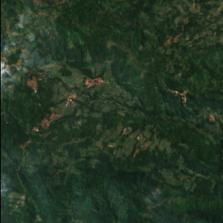

In [13]:
img = Image.open(fname)
img

Pembentukan data block

In [14]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label, # extracts the label category from the image's folder name 
                 batch_tfms=aug_transforms(mult=2)) # data augmentation (mult multiplies the default transformation values)

Load dan print conto batch

In [15]:
dls = blocks.dataloaders(path)

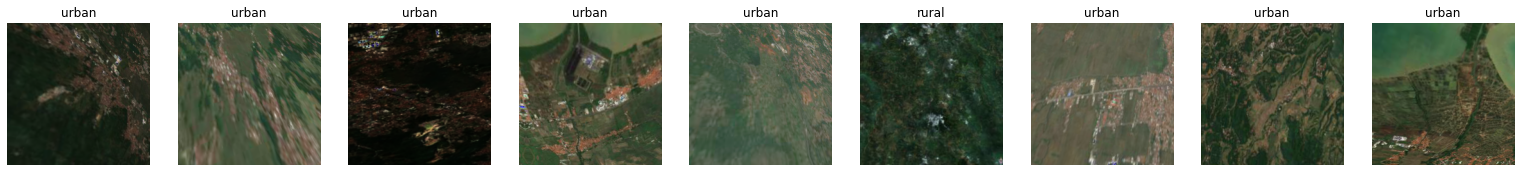

In [16]:
dls.show_batch(nrows=1)

In [17]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metricsc=[accuracy,bc, Precision(), Recall(),Recall(pos_label=0), f1s, roca]


Mencari batas maksimum untuk learning rate

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

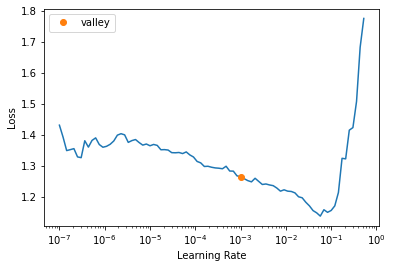

In [18]:
learn = vision_learner(dls, densenet121, metrics=metrics) 
learn.lr_find()

Smith fit one cycle terhadap densenet

In [19]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_labels = L(dls.train.items).map(dls.tfms[1])
valid_labels = L(dls.valid.items).map(dls.tfms[1])
train_labels = train_labels +valid_labels
train_imgs = dls.train.items
tst_imgs = dls.valid.items
import random
random.shuffle(train_imgs)
item_tfms = [ToTensor(),]
batch_tfms = [IntToFloatTensor(),]


In [30]:
val_pct = []
tst_preds = []
test_lab = []
for train_idx, val_idx in kf.split(np.array(train_imgs+tst_imgs), train_labels):
    blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=IndexSplitter(val_idx),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)
    dls = blocks.dataloaders(path)
    learn = vision_learner(dls, densenet121, metrics=metricsc) 
    learn.fit_one_cycle(3,1e-2)
    val_pct.append(learn.validate())
    tst_preds.append(learn.get_preds(ds_idx=1))

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.686513,0.401063,0.811242,0.726542,0.825447,0.930095,0.522989,0.746324,0.878136,00:29
1,0.506398,0.571147,0.826342,0.766758,0.854283,0.909953,0.623563,0.779153,0.876593,00:29
2,0.393916,0.375658,0.819631,0.769618,0.860252,0.889810,0.649425,0.776221,0.894519,00:29


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.708622,0.626288,0.812081,0.741771,0.836601,0.912114,0.571429,0.756876,0.845738,00:29
1,0.536739,0.403968,0.813758,0.765497,0.857968,0.882423,0.648571,0.770811,0.885650,00:29
2,0.403762,0.375529,0.820470,0.754388,0.844298,0.914489,0.594286,0.769155,0.901276,00:29


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.713481,0.525525,0.764064,0.751572,0.888166,0.777904,0.725240,0.723537,0.833029,00:29
1,0.506214,0.406472,0.823678,0.813592,0.918546,0.834852,0.792332,0.788626,0.898586,00:29
2,0.360681,0.353829,0.837112,0.775417,0.877483,0.905467,0.645367,0.783420,0.900529,00:29


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.711728,0.500548,0.802687,0.744775,0.856818,0.873696,0.615854,0.748706,0.853669,00:29
1,0.496222,0.415162,0.810243,0.765110,0.871645,0.865585,0.664634,0.763607,0.876523,00:29
2,0.351512,0.374878,0.828715,0.781636,0.878301,0.886443,0.676829,0.783769,0.891558,00:29


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.663883,0.468838,0.804366,0.792887,0.904459,0.817972,0.767802,0.769714,0.878005,00:29
1,0.462026,0.426442,0.784215,0.618690,0.780018,0.980415,0.256966,0.630623,0.889287,00:29
2,0.339835,0.369286,0.827036,0.799693,0.898795,0.859447,0.739938,0.788756,0.895172,00:30


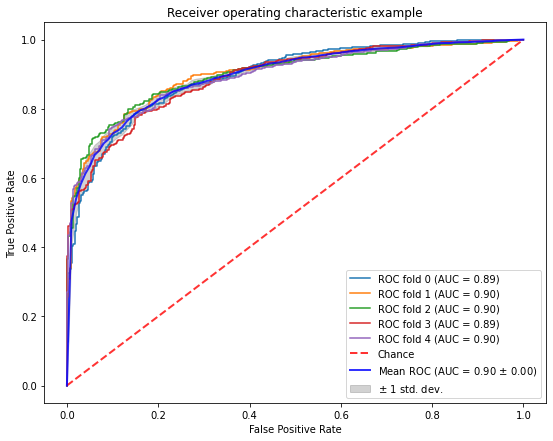

In [31]:
plot_multroc(tst_preds, k = 5)

In [32]:
file_name = "/content/drive/MyDrive/Colab Notebooks/pickle predictions/02. densenet predictions.pkl"
with open(file_name, "wb") as fp:   #Pickling
   pickle.dump(tst_preds, fp)

In [33]:
pd.DataFrame(val_pct).to_csv("/content/drive/MyDrive/Colab Notebooks/validate/02. densenet.csv")

Pemodelan densenet dengan metrik bersesuaian

In [34]:
pd.DataFrame(val_pct).mean()

0    0.369836
1    0.826593
2    0.776150
3    0.871826
4    0.891131
5    0.661169
6    0.780264
7    0.896611
dtype: float64

### Resnet

Pembentukan model semisal untuk resnet

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.005248074419796467)

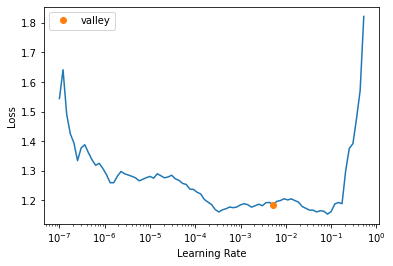

In [25]:
learn_rs = cnn_learner(dls, resnet50, metrics=metrics) 
learn_rs.lr_find()

In [35]:
val_pct_rs = []
tst_preds_rs = []
for train_idx, val_idx in kf.split(np.array(train_imgs+tst_imgs), train_labels):
    blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=IndexSplitter(val_idx),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)
    dls = blocks.dataloaders(path)
    learn_rs = vision_learner(dls, resnet50, metrics=metricsc) 
    learn_rs.fit_one_cycle(3,1e-2)
    val_pct_rs.append(learn_rs.validate())
    tst_preds_rs.append(learn_rs.get_preds(ds_idx=1))

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.720182,0.594159,0.788591,0.750232,0.856627,0.842417,0.658046,0.747266,0.827004,00:25
1,0.493412,0.435645,0.793624,0.718323,0.825000,0.899289,0.537356,0.731885,0.860067,00:25
2,0.359779,0.368162,0.828859,0.787956,0.873832,0.886256,0.689655,0.790877,0.898149,00:24


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.750769,0.435368,0.801175,0.743234,0.842582,0.883610,0.602857,0.751486,0.855283,00:25
1,0.495861,0.407050,0.821309,0.809240,0.901660,0.838480,0.780000,0.794145,0.894391,00:25
2,0.360045,0.379419,0.825503,0.771306,0.857788,0.902613,0.640000,0.781278,0.898219,00:25


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.722938,0.568826,0.802687,0.677027,0.818002,0.941913,0.412141,0.699461,0.841611,00:25
1,0.537309,0.437999,0.821159,0.724506,0.844560,0.928246,0.520767,0.744626,0.870663,00:24
2,0.412388,0.392294,0.830395,0.789365,0.892111,0.875854,0.702875,0.784633,0.888643,00:25


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.724084,0.596008,0.766583,0.619690,0.778837,0.946698,0.292683,0.631557,0.837482,00:25
1,0.495040,0.417521,0.780856,0.761842,0.882952,0.804171,0.719512,0.742826,0.861526,00:25
2,0.357742,0.385177,0.810243,0.747154,0.855866,0.887601,0.606707,0.754633,0.881486,00:24


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.689871,0.521152,0.771621,0.772366,0.901617,0.770737,0.773994,0.739362,0.858363,00:25
1,0.500809,0.399065,0.802687,0.744109,0.859251,0.872120,0.616099,0.747195,0.864751,00:25
2,0.359217,0.391569,0.817800,0.801132,0.905355,0.837558,0.764706,0.782467,0.887268,00:25


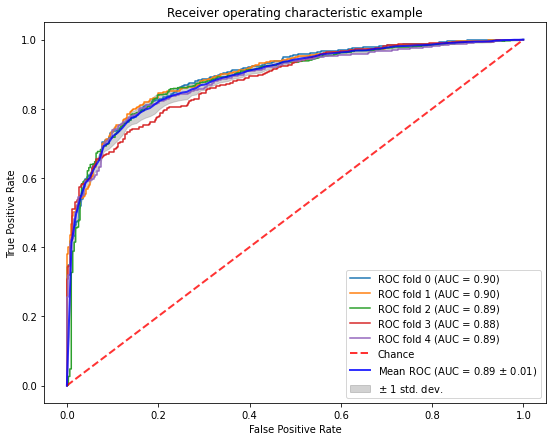

In [36]:
plot_multroc(tst_preds_rs, k = 5)

In [37]:
file_name = "/content/drive/MyDrive/Colab Notebooks/pickle predictions/02. resnet predictions.pkl"
with open(file_name, "wb") as fp:   #Pickling
   pickle.dump(tst_preds_rs, fp)

In [38]:
pd.DataFrame(val_pct_rs).mean()

0    0.383324
1    0.822560
2    0.779383
3    0.876990
4    0.877976
5    0.680789
6    0.778778
7    0.890753
dtype: float64

In [39]:
pd.DataFrame(val_pct_rs).to_csv("/content/drive/MyDrive/Colab Notebooks/validate/02. resnet.csv")